## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [32]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.Tanh(),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [33]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              Tanh-3                  [-1, 256]               0
            Linear-4                  [-1, 512]         131,584
              Tanh-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 337,674
Trainable params: 337,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.29
Estimated Total Size (MB): 1.31
----------------------------------------------------------------


Your experiments come here:

In [18]:

# Your experiments, training and validation loops here

In [34]:
def train_epoch(model, device, train_loader, test_loader, criterion, optimizer): 
    torch.manual_seed(5)

    model.train()

    current_test_accuracy = 0
    running_loss = 0
    pred = 0
    correct = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
    
    current_loss = running_loss / len(train_loader.dataset)
    print(f'Current train loss = {current_loss}')

    current_train_accuracy = correct / len(train_loader.dataset)
    print(f'Current train accuracy = {current_train_accuracy}')

    model.eval()

    current_test_loss = 0
    current_test_accuracy = 0 

    test_loss = 0
    correct = 0   
    running_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)

            test_loss = criterion(output, label)
            running_loss += test_loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    current_test_loss = running_loss / len(test_loader.dataset) 
    print(f'Current test loss = {current_test_loss}')

    current_test_accuracy = correct / len(test_loader.dataset)
    print(f'Current test accuracy = {current_test_accuracy}')

    return current_loss, current_train_accuracy, current_test_loss, current_test_accuracy



In [35]:
def train_model(epochs, model, device, train_loader, test_loader, loss_func, opt):
    test_loss_history = list()
    train_loss_history = list()
    test_ac_history = list()
    train_ac_history = list()

    train_loss = 0
    test_loss = 0
    test_ac = 0
    train_ac = 0
    for epoch in range(1, epochs+1):
        
        print(f'Training Epoch {epoch}')
        train_loss, train_ac, test_loss, test_ac = train_epoch(model, device, train_loader, test_loader, loss_func, opt)
        

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_ac_history.append(test_ac)
        train_ac_history.append(train_ac)

    return train_loss_history, test_loss_history, train_ac_history, test_ac_history

In [41]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.0003) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
epochs = 30

In [42]:
train_loss_history, test_loss_history, train_ac_history, test_ac_history = train_model(epochs, model, device, train_loader, test_loader, loss_func, opt)

Training Epoch 1
Current train loss = 0.004759866812328498
Current train accuracy = 0.7862
Current test loss = 0.0018318826407194137
Current test accuracy = 0.8322
Training Epoch 2
Current train loss = 0.003241500719388326
Current train accuracy = 0.8512666666666666
Current test loss = 0.00167291699051857
Current test accuracy = 0.8469
Training Epoch 3
Current train loss = 0.0029880516124268374
Current train accuracy = 0.86215
Current test loss = 0.0015954020753502845
Current test accuracy = 0.8524
Training Epoch 4
Current train loss = 0.002824353574216366
Current train accuracy = 0.8695333333333334
Current test loss = 0.0015422032609581947
Current test accuracy = 0.8576
Training Epoch 5
Current train loss = 0.0026977650245030723
Current train accuracy = 0.8746666666666667
Current test loss = 0.0015006742268800736
Current test accuracy = 0.8615
Training Epoch 6
Current train loss = 0.002591597560048103
Current train accuracy = 0.8787833333333334
Current test loss = 0.001465745157003402

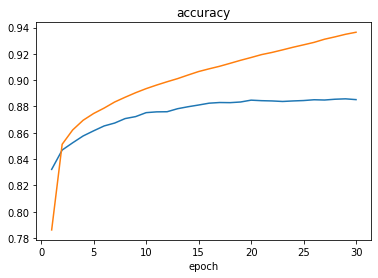

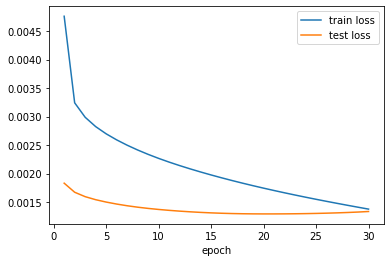

In [43]:
grid = np.arange(1, epochs + 1)

plt.plot(grid, test_ac_history, label='test accuracy')
plt.plot(grid, train_ac_history, label='train accuracy')
plt.xlabel("epoch")
plt.title("accuracy")
plt.show()

plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("epoch")
plt.legend()
plt.show()


In [44]:
print(f'Test accuracy = {test_ac_history[-1]}')

Test accuracy = 0.8852


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [45]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 28*28*2),
            nn.ReLU(),
            nn.Linear(28*28*2, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [46]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                  [-1, 512]         803,328
              Tanh-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 100]          25,700
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 2,192,246
Trainable params: 2,192,246
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 8.36
Estimat

Training Epoch 1
Current train loss = 0.004620448195934296
Current train accuracy = 0.7889166666666667
Current test loss = 0.0017795004934072494
Current test accuracy = 0.8395
Training Epoch 2
Current train loss = 0.0029722280365725357
Current train accuracy = 0.8623
Current test loss = 0.0015650827050209045
Current test accuracy = 0.8563
Training Epoch 3
Current train loss = 0.0026290319701035817
Current train accuracy = 0.87615
Current test loss = 0.0014273600980639458
Current test accuracy = 0.8685
Training Epoch 4
Current train loss = 0.002414798280100028
Current train accuracy = 0.8862166666666667
Current test loss = 0.001356926465034485
Current test accuracy = 0.8746
Training Epoch 5
Current train loss = 0.002260904302323858
Current train accuracy = 0.89335
Current test loss = 0.0013282928586006164
Current test accuracy = 0.8761
Training Epoch 6
Current train loss = 0.0021343297729889553
Current train accuracy = 0.8981666666666667
Current test loss = 0.001314346681535244
Current 

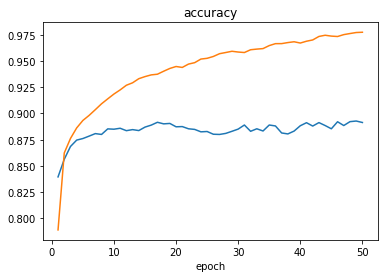

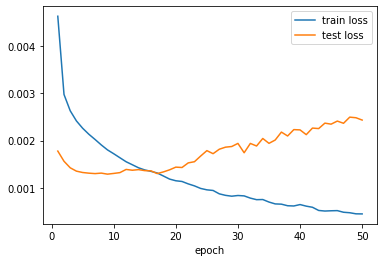

In [48]:
model_over = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model_over.parameters(), lr=0.0003) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here
epochs = 50

train_loss_history, test_loss_history, train_ac_history, test_ac_history = train_model(epochs, model_over, device, train_loader, test_loader, loss_func, opt)

grid = np.arange(1, epochs + 1)

plt.plot(grid, test_ac_history, label='test accuracy')
plt.plot(grid, train_ac_history, label='train accuracy')
plt.xlabel("epoch")
plt.title("accuracy")
plt.show()

plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("epoch")
plt.legend()
plt.show()


На графиках видно переобучение модели, график train loss уменьшается, а test loss начинает быстро расти

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [56]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 28*28*2),
            nn.BatchNorm1d(28*28*2),
            nn.Dropout(0.8),
            nn.ReLU(),
            nn.Linear(28*28*2, 512),
            nn.Dropout(0.8),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(256, 100),
            nn.Dropout(0.8),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [57]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
       BatchNorm1d-3                 [-1, 1568]           3,136
           Dropout-4                 [-1, 1568]               0
              ReLU-5                 [-1, 1568]               0
            Linear-6                  [-1, 512]         803,328
           Dropout-7                  [-1, 512]               0
              Tanh-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
      BatchNorm1d-10                  [-1, 256]             512
             ReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                  [-1, 100]          25,700
          Dropout-14                  [

Training Epoch 1
Current train loss = 0.01591825206875801
Current train accuracy = 0.2212
Current test loss = 0.004398730570077896
Current test accuracy = 0.5366
Training Epoch 2
Current train loss = 0.009517483658591907
Current train accuracy = 0.5043833333333333
Current test loss = 0.003842064380645752
Current test accuracy = 0.6418
Training Epoch 3
Current train loss = 0.007098115733265877
Current train accuracy = 0.63585
Current test loss = 0.003396231508255005
Current test accuracy = 0.7379
Training Epoch 4
Current train loss = 0.005737675237655639
Current train accuracy = 0.7250166666666666
Current test loss = 0.003000459334254265
Current test accuracy = 0.774
Training Epoch 5
Current train loss = 0.00477029663225015
Current train accuracy = 0.7867333333333333
Current test loss = 0.0028739332228899
Current test accuracy = 0.7881
Training Epoch 6
Current train loss = 0.00395814641614755
Current train accuracy = 0.8357333333333333
Current test loss = 0.002562232083082199
Current te

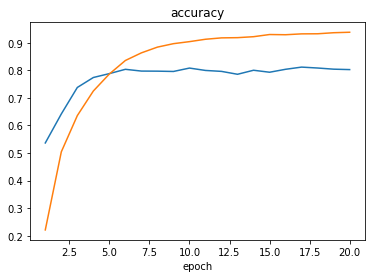

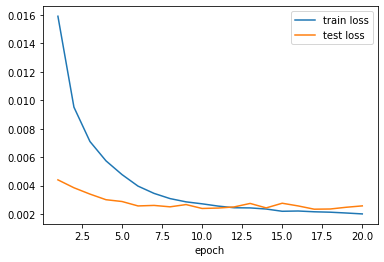

In [61]:
model_fix = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model_fix.parameters(), lr=0.0003, weight_decay=0.008) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE# YOUR CODE HERE

# Your experiments, come here
epochs = 20

train_loss_history, test_loss_history, train_ac_history, test_ac_history = train_model(epochs, model_fix, device, train_loader, test_loader, loss_func, opt)

grid = np.arange(1, epochs + 1)

plt.plot(grid, test_ac_history, label='test accuracy')
plt.plot(grid, train_ac_history, label='train accuracy')
plt.xlabel("epoch")
plt.title("accuracy")
plt.show()

plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

Для борьбы с переобучением использовались Batch normalization и Dropout, но они не помогали. Дополнение L2 регулярицацией помогло.
